In [1]:
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Reading Data

In [2]:
# Create a SparkSession
spark = SparkSession.builder.master("local[4]").appName("ClusterShop").getOrCreate()
# Read the Excel file using Pandas
df_pandas = pd.read_excel("Online Retail.xlsx",na_values='')
# Convert the Pandas DataFrame to PySpark DataFrame
df_spark = spark.createDataFrame(df_pandas)

23/04/16 16:21:31 WARN Utils: Your hostname, hazemabdo resolves to a loopback address: 127.0.1.1; using 192.168.1.2 instead (on interface enp8s0)
23/04/16 16:21:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/16 16:21:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Analyzing Data

In [3]:
spark

In [4]:
print(df_spark.rdd.getNumPartitions())

4


In [5]:
df_spark.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [64]:
df_pandas.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [78]:
df_pandas.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [81]:
df_pandas.isnull().sum()/df_pandas.shape[0]

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

* Note: 25% of the data not assigned to a certain customer as CustomerID is NaN

In [82]:
# filter out the missing values using map 
import math
df_spark = df_spark.rdd.map(lambda x: x if not math.isnan( x['CustomerID'])  else None).filter(lambda x: x is not None).toDF()

23/04/16 23:57:12 WARN TaskSetManager: Stage 674 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


* we just remove them as we will cluster customers based on their purchase history

In [84]:
#print len of df_spark
print(df_spark.count())

23/04/16 23:58:02 WARN TaskSetManager: Stage 678 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


406829


### InvoiceNo
uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

In [111]:
#count_invoices is unique invoice numbers
count_transactions = df_spark.select('InvoiceNo').distinct().count()
count_cancelled_transactions= df_spark.filter(df_spark['InvoiceNo'].contains('C')).select('InvoiceNo').distinct().count()
cancelled_percentage = count_cancelled_transactions/count_transactions
data = [(count_transactions, count_cancelled_transactions, cancelled_percentage)]
columns = ["count_transactions", "count cancelled transactions", "cancelled_percentage"]
invoice_no_characteristics = spark.createDataFrame(data, columns)
invoice_no_characteristics.toPandas()

23/04/17 02:58:44 WARN TaskSetManager: Stage 900 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/17 02:58:49 WARN TaskSetManager: Stage 906 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,count_transactions,count cancelled transactions,cancelled_percentage
0,22190,3654,0.164669


* almost 16% of orders are cancelled

23/04/16 23:59:27 WARN TaskSetManager: Stage 697 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


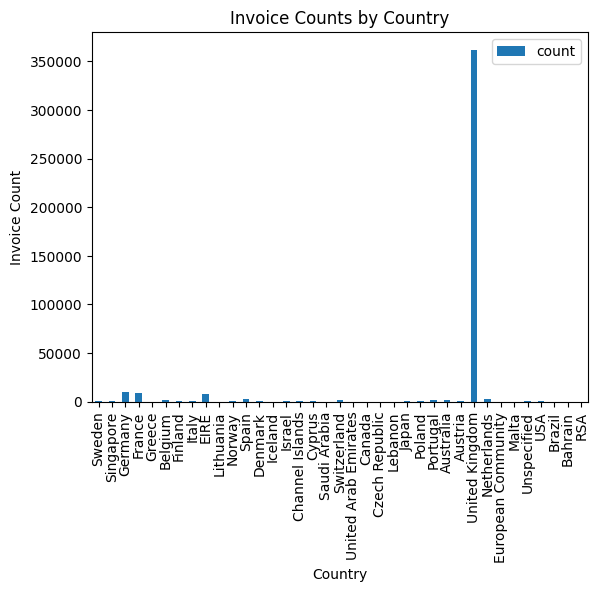

In [86]:
invoice_counts = df_spark.groupBy("Country").count()
pandas_df = invoice_counts.toPandas()
pandas_df.plot(kind="bar", x="Country", y="count")
plt.title("Invoice Counts by Country")
plt.xlabel("Country")
plt.ylabel("Invoice Count")
plt.show()

23/04/16 23:59:34 WARN TaskSetManager: Stage 700 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


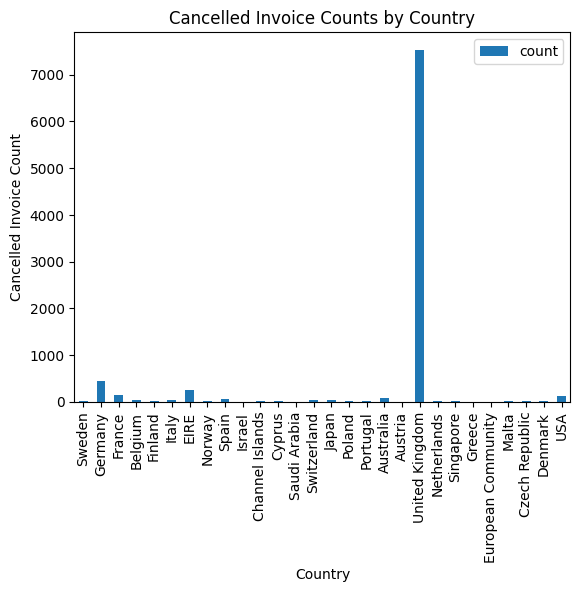

In [87]:
cancelled_invoice_counts = df_spark.filter(df_spark.InvoiceNo.startswith('C')).groupBy("Country").count()
pandas_df = cancelled_invoice_counts.toPandas()
pandas_df.plot(kind="bar", x="Country", y="count")
plt.title("Cancelled Invoice Counts by Country")
plt.xlabel("Country")
plt.ylabel("Cancelled Invoice Count")
plt.show()

In [88]:
from pyspark.sql.functions import count, sum, when, col
invoice_counts = df_spark.groupBy("Country").agg(count("*").alias("total_invoices"), sum(when(col("InvoiceNo").startswith("C"), 1).otherwise(0)).alias("cancelled_invoices"))
invoice_counts = invoice_counts.withColumn("cancelled_percentage", col("cancelled_invoices") / col("total_invoices") * 100)
#show top 5 countries with highest percentage of cancelled invoices
invoice_counts.orderBy(col("cancelled_percentage").desc()).toPandas().head(5)

23/04/16 23:59:41 WARN TaskSetManager: Stage 703 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,Country,total_invoices,cancelled_invoices,cancelled_percentage
0,USA,291,112,38.487973
1,Czech Republic,30,5,16.666667
2,Malta,127,15,11.811024
3,Japan,358,37,10.335196
4,Saudi Arabia,10,1,10.000000


### StockCode
uniquely assigned to each distinct product

In [89]:
stock_code_characteristics = spark.createDataFrame([(df_spark.select('StockCode').count(), df_spark.select('StockCode').distinct().count(), df_spark.filter(df_spark.StockCode.isNull()).count())], ['number_of_items', 'number_of_unique_items', 'number_of_null_values'])
stock_code_characteristics.toPandas()

23/04/16 23:59:48 WARN TaskSetManager: Stage 711 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/16 23:59:55 WARN TaskSetManager: Stage 714 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/17 00:00:03 WARN TaskSetManager: Stage 720 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,number_of_items,number_of_unique_items,number_of_null_values
0,406829,3684,0


In [90]:
#most popular items
df_spark.groupBy('StockCode').count().orderBy('count', ascending=False).toPandas().head(10)

23/04/17 00:00:10 WARN TaskSetManager: Stage 724 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,StockCode,count
0,85123A,2077
1,22423,1905
2,85099B,1662
3,84879,1418
4,47566,1416
5,20725,1359
6,22720,1232
7,POST,1196
8,20727,1126
9,22197,1118


In [91]:
# least popular items
df_spark.groupBy('StockCode').count().orderBy('count', ascending=True).toPandas().head(10)

23/04/17 00:00:16 WARN TaskSetManager: Stage 732 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,StockCode,count
0,90197B,1
1,79320,1
2,21645,1
3,90183C,1
4,85170A,1
5,90027A,1
6,79323W,1
7,37330,1
8,90039C,1
9,21144,1


### Description
Product (item) name. Nominal.

In [92]:
description_characteristics = spark.createDataFrame([(df_spark.select('Description').count(), df_spark.select('Description').distinct().count(), df_spark.filter(df_spark.Description.isNull()).count())], ['number_of_items', 'number_of_unique_items', 'number_of_null_values'])
description_characteristics.toPandas()

23/04/17 00:00:23 WARN TaskSetManager: Stage 740 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/17 00:00:29 WARN TaskSetManager: Stage 743 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/17 00:00:35 WARN TaskSetManager: Stage 749 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,number_of_items,number_of_unique_items,number_of_null_values
0,406829,3896,0


In [93]:
# Top products by frequency
df_spark.groupBy('Description').count().orderBy('count', ascending=False).toPandas().head(10)

23/04/17 00:00:41 WARN TaskSetManager: Stage 753 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,Description,count
0,WHITE HANGING HEART T-LIGHT HOLDER,2070
1,REGENCY CAKESTAND 3 TIER,1905
2,JUMBO BAG RED RETROSPOT,1662
3,ASSORTED COLOUR BIRD ORNAMENT,1418
4,PARTY BUNTING,1416
5,LUNCH BAG RED RETROSPOT,1358
6,SET OF 3 CAKE TINS PANTRY DESIGN,1232
7,POSTAGE,1196
8,LUNCH BAG BLACK SKULL.,1126
9,PACK OF 72 RETROSPOT CAKE CASES,1080


In [94]:
# Bottom products by frequency
df_spark.groupBy('Description').count().orderBy('count', ascending=True).toPandas().head(10)

23/04/17 00:00:48 WARN TaskSetManager: Stage 761 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,Description,count
0,POTTING SHED SOW 'N' GROW SET,1
1,PINK BOUDOIR T-LIGHT HOLDER,1
2,BIRTHDAY BANNER TAPE,1
3,JADE CRYSTAL+GLASS BRACELET,1
4,PINK PAINTED KASHMIRI CHAIR,1
5,PINK MARSHMALLOW SCARF KNITTING KIT,1
6,CREAM SWEETHEART SHELF + HOOKS,1
7,BLUE LEAVES AND BEADS PHONE CHARM,1
8,"FLOWER GLASS GARLD NECKL36""TURQUOIS",1
9,NEW BAROQUE B'FLY NECKLACE CRYSTAL,1


### Quantity
The quantities of each product (item) per transaction. Numeric.


In [95]:
df_spark.select('Quantity').describe().toPandas()

23/04/17 00:00:55 WARN TaskSetManager: Stage 769 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,summary,Quantity
0,count,406829
1,mean,12.06130339774205
2,stddev,248.6933700188252
3,min,-80995
4,max,80995


In [96]:
null_values=df_spark.filter(df_spark.Quantity.isNull()).count()
print(f"Number of null values in Quantity column: {null_values}")

23/04/17 00:01:01 WARN TaskSetManager: Stage 772 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


Number of null values in Quantity column: 0


In [97]:
negative_characteristics = spark.createDataFrame([(df_spark.filter(df_spark.Quantity < 0).count(), (df_spark.filter(df_spark.Quantity < 0).count()/df_spark.count())*100)], ['number_of_negative_quantities', 'percentage_of_negative_quantities'])
negative_characteristics.toPandas()

23/04/17 00:01:07 WARN TaskSetManager: Stage 775 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/17 00:01:12 WARN TaskSetManager: Stage 778 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/17 00:01:18 WARN TaskSetManager: Stage 781 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,number_of_negative_quantities,percentage_of_negative_quantities
0,8905,2.18888


In [98]:
df_spark.groupBy('Country').sum('Quantity').orderBy('sum(Quantity)', ascending=False).toPandas().head(5)

23/04/17 00:01:25 WARN TaskSetManager: Stage 785 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,Country,sum(Quantity)
0,United Kingdom,4008533
1,Netherlands,200128
2,EIRE,136329
3,Germany,117448
4,France,109848


In [ ]:
#top 5 countries by percentage of ne

In [99]:
df_spark.groupBy('Country').sum('Quantity').orderBy('sum(Quantity)', ascending=True).toPandas().head(5)

23/04/17 00:01:31 WARN TaskSetManager: Stage 793 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,Country,sum(Quantity)
0,Saudi Arabia,75
1,Bahrain,260
2,RSA,352
3,Brazil,356
4,Lebanon,386


In [100]:
df_spark.groupBy('StockCode').sum('Quantity').orderBy('sum(Quantity)', ascending=False).toPandas().head(5)

23/04/17 00:01:37 WARN TaskSetManager: Stage 801 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,StockCode,sum(Quantity)
0,84077,53215
1,22197,48712
2,85099B,45066
3,84879,35314
4,85123A,34204


In [101]:
df_spark.groupBy('StockCode').sum('Quantity').orderBy('sum(Quantity)', ascending=True).toPandas().head(5)

23/04/17 00:01:44 WARN TaskSetManager: Stage 809 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,StockCode,sum(Quantity)
0,84347,-1460
1,D,-1194
2,21645,-24
3,CRUK,-16
4,21144,-12


In [102]:
from pyspark.sql.functions import month 
#TOP FIVE MONTHES BY SUM OF QUANTITY
df_spark.groupBy(month('InvoiceDate')).sum('Quantity').orderBy('sum(Quantity)', ascending=False).toPandas().head(5)

23/04/17 00:01:51 WARN TaskSetManager: Stage 817 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,month(InvoiceDate),sum(Quantity)
0,11,669915
1,10,569666
2,9,537496
3,12,500198
4,8,386612
